In [1]:
# pip install git+https://github.com/crispitagorico/sigkernel.git

### If parameter to vary is depth, generate Brownian motion outside loop (otherwise different sets of paths are generated for different parameter values, so the test is not fair). For all other parameters, the BM paths must be regenerated for each value of that parameter. But what about the time increment parameter?

## Untruncated signature kernel (Goursat PDE)
#### (a) $\phi \equiv 1$
#### (b) $\phi(k) = \mathbb{E}[\pi^k]$ where $\pi$ is a random variable

#### Check code below is doing centering correctly
#### Dyadic order is another parameter that can be varied

## Projection onto principal components (note: here we look at the covariance matrix of transformed features, but kernel PCA is supposed to use another covariance matrix)

In [9]:
# from tensorflow import keras
# from keras_sig import jax_gpu_signature



[Depth = 4]
  Standard PCA explained variance ratios:          [0.291, 0.5636, 0.8146, 0.8459, 0.8756, 0.9045, 0.9154, 0.9259, 0.9358, 0.9414, 0.9465, 0.9515, 0.955, 0.9584, 0.9616, 0.9638, 0.966, 0.968, 0.9695, 0.9711, 0.9726, 0.9739, 0.975, 0.9761, 0.9771, 0.978, 0.9789, 0.9796, 0.9803, 0.981]
  Signature PCA explained variance ratios:         [0.0954, 0.163, 0.2245, 0.2804, 0.3265, 0.3694, 0.4086, 0.4425, 0.4721, 0.498, 0.521, 0.5426, 0.5617, 0.5792, 0.596, 0.6122, 0.627, 0.6409, 0.6544, 0.667, 0.6791, 0.6907, 0.702, 0.7128, 0.7228, 0.7327, 0.7424, 0.7517, 0.7608, 0.7694]
  Signature+Time PCA explained variance ratios:    [0.1935, 0.3717, 0.5296, 0.6469, 0.751, 0.8476, 0.8855, 0.921, 0.9534, 0.9585, 0.9632, 0.9678, 0.9701, 0.9723, 0.9743, 0.9761, 0.9779, 0.9796, 0.9813, 0.9828, 0.9841, 0.985, 0.9859, 0.9868, 0.9876, 0.9884, 0.9892, 0.9899, 0.9906, 0.9913]
  Logsignature PCA explained variance ratios:      [0.2169, 0.3821, 0.5059, 0.5838, 0.6399, 0.6875, 0.7285, 0.7674, 0.8012, 0.83

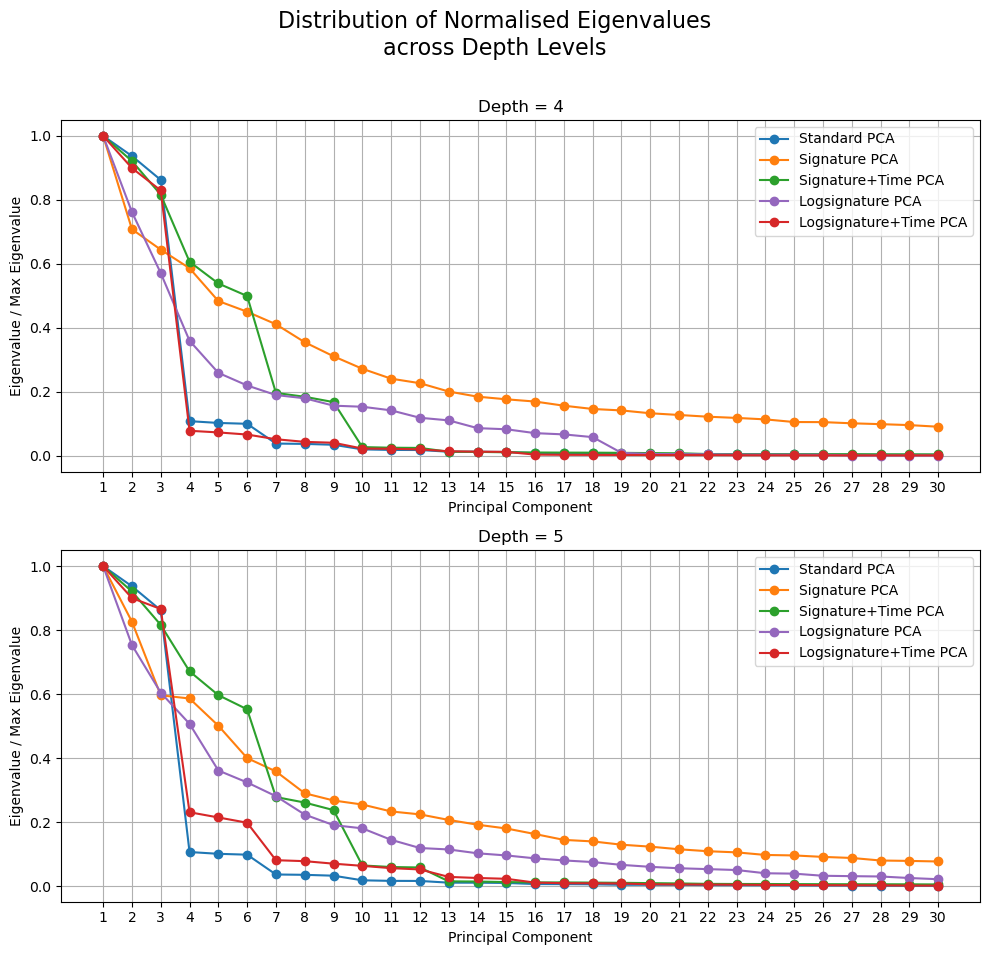

In [255]:
import iisignature
import numpy as np
import torch
import matplotlib.pyplot as plt

# Default parameters
num_samples    = 1000
len_x_default  = 300  # number of points in each path
len_x          = len_x_default
drift_default  = 0
drift          = drift_default
volatility_default = 1
volatility     = volatility_default
time_increment_default = 1
time_increment = time_increment_default
depth_default  = 5  # signature truncation level
depth          = depth_default
d_default      = 3  # path dimension
d              = d_default
num_pcs_default = 30   # number of principal components to keep
num_pcs        = num_pcs_default

# Parameter lists (for exploring how PCA‐eigenvalue spectra change)
path_dimension_list = [3, 4, 5]
depth_list          = [4, 5]  
drift_list          = [0.01, 0.1, 1, 10]
volatility_list     = [0.001, 0.01, 0.1, 1, 10]
time_increment_list = [0.001, 0.01, 0.1, 1, 10]
path_length_list    = [100, 300, 1000]

parameter_to_vary = 'depth'

if parameter_to_vary == 'depth':
    parameter_list = depth_list
elif parameter_to_vary == 'drift':
    parameter_list = drift_list
elif parameter_to_vary == 'volatility':
    parameter_list = volatility_list
elif parameter_to_vary == 'time increment':
    parameter_list = time_increment_list
elif parameter_to_vary == 'path length':
    parameter_list = path_length_list
elif parameter_to_vary == 'path dimension':
    parameter_list = path_dimension_list
else:
    raise ValueError("Unknown parameter_to_vary.")


# ----------------------------------------------------------------------------
# 1) Generate a batch of Brownian-motion–type paths (spatial only)
# ----------------------------------------------------------------------------
def generate_brownian_motion(num_samples, len_x, drift, volatility,
                             initial_condition=None, time_increment=0.1):
    """
    Returns a torch.Tensor of shape (num_samples, len_x, d):
      X[*, 0, :] = 0  (if initial_condition is zero)
      X[*, t, :] = cumulative sum of (dW + drift*Δt) up to index t.
    We do NOT append time here; this is purely spatial.
    """
    t_x = torch.linspace(0, (len_x - 1) * time_increment, len_x,
                         dtype=torch.float64).view(1, len_x, 1)  # (1, len_x, 1)
    dW = torch.randn(num_samples, len_x - 1, d, dtype=torch.float64) \
         * torch.sqrt(torch.tensor(time_increment, dtype=torch.float64)) \
         * volatility
    dW = torch.cat([
        torch.zeros(num_samples, 1, d, dtype=torch.float64),
        dW
    ], dim=1)  # (num_samples, len_x, d)
    X = torch.cumsum(dW, dim=1) + drift * t_x
    if initial_condition is not None:
        X = X + initial_condition.view(1, 1, d)
    return X  # (num_samples, len_x+1, d)


# ----------------------------------------------------------------------------
# 2) PCA helper (returns reconstruction too)
# ----------------------------------------------------------------------------
def perform_pca(X: np.ndarray, n_components: int):
    """
    Input:
      X: (n_samples, n_features)
    Returns:
      eigenvalues:        (n_features,) sorted descending
      projections:       (n_samples, k)         # principal‐component coefficients
      X_reconstructed:   (n_samples, n_features) # back‐projection into original basis
    """
    mean_X = np.mean(X, axis=0, keepdims=True)         # (1, n_features)
    X_centered = X - mean_X                             # (n_samples, n_features)
    cov = np.cov(X_centered, rowvar=False)              # (n_features, n_features)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    idx_desc = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx_desc]
    eigenvectors = eigenvectors[:, idx_desc]             # columns are sorted eigenvectors
    n_features = eigenvalues.shape[0]
    k = min(n_components, n_features)
    W = eigenvectors[:, :k]                              # (n_features, k)
    projections = X_centered @ W                          # (n_samples, k)
    X_reconstructed = projections @ W.T + mean_X          # (n_samples, n_features)
    return eigenvalues, projections, X_reconstructed


def cumulative_explained_variance(eigenvalues: np.ndarray, k):
    total_var = np.sum(eigenvalues)
    explained = np.cumsum(eigenvalues[:k])
    return [round(float(ev) / total_var, 4) for ev in explained]


# ----------------------------------------------------------------------------
# 3) Augmentation routines (basepoint first, then time)
# ----------------------------------------------------------------------------
def add_basepoint_zero_spatial_only(paths_spatial: np.ndarray) -> np.ndarray:
    batch, len_x_, d_ = paths_spatial.shape
    zero_spatial = np.zeros((batch, 1, d_), dtype=paths_spatial.dtype)
    return np.concatenate([zero_spatial, paths_spatial], axis=1)  # (batch, len_x+1, d)


def add_time_after_basepoint(paths_spatial_with_base: np.ndarray,
                             time_increment: float) -> np.ndarray:
    batch, len_x_plus1, d_ = paths_spatial_with_base.shape
    times = np.arange(len_x_plus1, dtype=np.float64).reshape(1, len_x_plus1, 1) * time_increment
    times = np.tile(times, (batch, 1, 1))  # (batch, len_x+1, 1)
    return np.concatenate([times, paths_spatial_with_base], axis=2)  # (batch, len_x+1, d+1)


# ----------------------------------------------------------------------------
# 4) Batch signature / logsignature routines
# ----------------------------------------------------------------------------
def batch_signature(paths_spatial: np.ndarray, depth: int) -> np.ndarray:
    paths_with_base = add_basepoint_zero_spatial_only(paths_spatial)  # (batch, len_x+1, d)
    sigs = []
    for path in paths_with_base:
        sig = iisignature.sig(np.ascontiguousarray(path, dtype=np.float64), depth)
        sigs.append(sig)
    return np.array(sigs)  # (batch, sig_dim)


def batch_logsignature(paths_spatial: np.ndarray, depth: int) -> np.ndarray:
    paths_with_base = add_basepoint_zero_spatial_only(paths_spatial)  # (batch, len_x+1, d)
    state = iisignature.prepare(paths_spatial.shape[2], depth)
    logsigs = []
    for path in paths_with_base:
        logsig = iisignature.logsig(np.ascontiguousarray(path, dtype=np.float64), state)
        logsigs.append(logsig)
    return np.array(logsigs)  # (batch, logsig_dim)


def batch_signature_time(paths_spatial: np.ndarray,
                         depth: int,
                         time_increment: float) -> np.ndarray:
    paths_with_base = add_basepoint_zero_spatial_only(paths_spatial)  # (batch, len_x+1, d)
    paths_time = add_time_after_basepoint(paths_with_base, time_increment)  # (batch, len_x+1, d+1)
    sigs_time = []
    for path in paths_time:
        sig_t = iisignature.sig(np.ascontiguousarray(path, dtype=np.float64), depth)
        sigs_time.append(sig_t)
    return np.array(sigs_time)  # (batch, sig_dim)


def batch_logsignature_time(paths_spatial: np.ndarray,
                            depth: int,
                            time_increment: float) -> np.ndarray:
    paths_with_base = add_basepoint_zero_spatial_only(paths_spatial)  # (batch, len_x+1, d)
    paths_time = add_time_after_basepoint(paths_with_base, time_increment)  # (batch, len_x+1, d+1)
    state = iisignature.prepare(paths_time.shape[2], depth)  # channels = d+1
    logsigs_time = []
    for path in paths_time:
        logsig_t = iisignature.logsig(np.ascontiguousarray(path, dtype=np.float64), state)
        logsigs_time.append(logsig_t)
    return np.array(logsigs_time)  # (batch, logsig_dim)


# ----------------------------------------------------------------------------
# ───── MAIN LOOP ─────
# ----------------------------------------------------------------------------

# 1) If varying “depth,” build X_fixed one time here; otherwise will generate inside the loop.
if parameter_to_vary == 'depth':
    initial_condition = torch.zeros(d, dtype=torch.float64)
    X_fixed = generate_brownian_motion(
        num_samples, len_x,
        drift=drift,
        volatility=volatility,
        initial_condition=initial_condition,
        time_increment=time_increment
    )  # (num_samples, len_x, d)

m = len(parameter_list)
fig, axs = plt.subplots(m, 1, figsize=(10, 5 * m))
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']

# Dictionaries to store every batch of paths and every reconstruction
X_dict = {}            # X_dict[param_val] = torch.Tensor of shape (1000, len_x, d)
X_np_dict = {}         # X_np_dict[param_val] = NumPy array (1000, len_x, d)
projections_dict = {}  # projections_dict[param_val][method] = (1000, k_method)
reconstructions_dict = {}  # reconstructions_dict[param_val][method] = (1000, n_features_method)

for i, parameter_value in enumerate(parameter_list):
    # 2) Update whichever parameter we’re varying
    if parameter_to_vary == 'depth':
        depth = parameter_value
    elif parameter_to_vary == 'drift':
        drift = parameter_value
    elif parameter_to_vary == 'volatility':
        volatility = parameter_value
    elif parameter_to_vary == 'time increment':
        time_increment = parameter_value
    elif parameter_to_vary == 'path length':
        len_x = parameter_value
    elif parameter_to_vary == 'path dimension':
        d = parameter_value

    # 3) Generate X for this iteration
    if parameter_to_vary == 'depth':
        # Reuse X_fixed whenever we vary depth 
        X = X_fixed.clone()
    else:
        # Regenerate a fresh batch because len_x, drift, etc. may have changed
        initial_condition = torch.zeros(d, dtype=torch.float64)
        X = generate_brownian_motion(
            num_samples, len_x,
            drift=drift,
            volatility=volatility,
            initial_condition=initial_condition,
            time_increment=time_increment
        )

    # 4) Store this iteration’s paths
    X_dict[parameter_value] = X.clone()
    X_np = X.numpy()
    X_np_dict[parameter_value] = X_np.copy()

    # 5) Prepare feature spaces
    X_flat_for_param    = X_np.reshape(num_samples, -1)                # shape (num_samples, len_x*d)
    sig_for_param       = batch_signature(X_np, depth)                 # shape (num_samples, n_sig)
    sig_time_for_param  = batch_signature_time(X_np, depth, time_increment)  # (num_samples, n_sig_time)
    logsig_for_param    = batch_logsignature(X_np, depth)              # (num_samples, n_logsig)
    logsig_time_for_param = batch_logsignature_time(X_np, depth, time_increment) # (num_samples, n_logsig_time)

    # 6) Create entries in both dicts
    projections_dict[parameter_value]     = {}
    reconstructions_dict[parameter_value] = {}

    # ────────────── STORE RECONSTRUCTIONS ──────────────

    # (a) Standard PCA on flattened paths:
    eigen_flat, proj_flat, recon_flat = perform_pca(X_flat_for_param, num_pcs)
    projections_dict[parameter_value]["standard"] = proj_flat          # shape = (num_samples, k_std)
    reconstructions_dict[parameter_value]["standard"] = recon_flat    # shape = (num_samples, len_x*d)

    # (b) Signature PCA:
    eigen_sig, proj_sig, recon_sig = perform_pca(sig_for_param, num_pcs)
    projections_dict[parameter_value]["signature"] = proj_sig         # (num_samples, k_sig)
    reconstructions_dict[parameter_value]["signature"] = recon_sig    # (num_samples, n_sig)

    # (c) Signature+Time PCA:
    eigen_sig_time, proj_sig_time, recon_sig_time = perform_pca(sig_time_for_param, num_pcs)
    projections_dict[parameter_value]["signature+time"] = proj_sig_time    # (num_samples, k_sig_time)
    reconstructions_dict[parameter_value]["signature+time"] = recon_sig_time  # (num_samples, n_sig_time)

    # (d) Logsignature PCA:
    eigen_logsig, proj_logsig, recon_logsig = perform_pca(logsig_for_param, num_pcs)
    projections_dict[parameter_value]["logsignature"] = proj_logsig       # (num_samples, k_logsig)
    reconstructions_dict[parameter_value]["logsignature"] = recon_logsig  # (num_samples, n_logsig)

    # (e) Logsignature+Time PCA:
    eigen_logsig_time, proj_logsig_time, recon_logsig_time = perform_pca(logsig_time_for_param, num_pcs)
    projections_dict[parameter_value]["logsignature+time"] = proj_logsig_time    # (num_samples, k_logsig_time)
    reconstructions_dict[parameter_value]["logsignature+time"] = recon_logsig_time  # (num_samples, n_logsig_time)

    # ────────────── PLOTTING ──────────────

    # Choose the correct Axes object (handle single vs. multiple subplots)
    if m == 1:
        ax = axs
    else:
        ax = axs[i]

    ax.set_title(f"{parameter_to_vary.capitalize()} = {parameter_value}")
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Eigenvalue / Max Eigenvalue")
    ax.set_xticks(np.arange(1, num_pcs + 1))
    ax.grid(True)

    # Standard PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_flat[:num_pcs] / np.max(eigen_flat),
        label="Standard PCA",
        marker='o',
        color=colours[0]
    )

    # Signature PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_sig[:num_pcs] / np.max(eigen_sig),
        label="Signature PCA",
        marker='o',
        color=colours[1]
    )

    # Signature+Time PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_sig_time[:num_pcs] / np.max(eigen_sig_time),
        label="Signature+Time PCA",
        marker='o',
        color=colours[2]
    )

    # Logsignature PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_logsig[:num_pcs] / np.max(eigen_logsig),
        label="Logsignature PCA",
        marker='o',
        color=colours[3]
    )

    # Logsignature+Time PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_logsig_time[:num_pcs] / np.max(eigen_logsig_time),
        label="Logsignature+Time PCA",
        marker='o',
        color=colours[4]
    )

    # Print the first 4 cumulative explained‐variance ratios
    print(f"\n[{parameter_to_vary.capitalize()} = {parameter_value}]")
    print("  Standard PCA explained variance ratios:         ",
          cumulative_explained_variance(eigen_flat, num_pcs))
    print("  Signature PCA explained variance ratios:        ",
          cumulative_explained_variance(eigen_sig, num_pcs))
    print("  Signature+Time PCA explained variance ratios:   ",
          cumulative_explained_variance(eigen_sig_time, num_pcs))
    print("  Logsignature PCA explained variance ratios:     ",
          cumulative_explained_variance(eigen_logsig, num_pcs))
    print("  Logsignature+Time PCA explained variance ratios:",
          cumulative_explained_variance(eigen_logsig_time, num_pcs))

    ax.legend()

plt.suptitle(
    f"Distribution of Normalised Eigenvalues\n" +
    f"across {parameter_to_vary.replace('_',' ').title()} Levels",
    fontsize=16
)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Restore all defaults:
len_x = len_x_default
drift = drift_default
volatility = volatility_default
time_increment = time_increment_default
depth = depth_default
d = d_default


## Use sigkernel instead ie untruncated signature kernel for the signature+time case. REDUCE SAMPLE SIZE to 50

In [256]:
param_val = len_x
param_val = 5

reconstructed_signature = reconstructions_dict[param_val]["signature+time"][i]
reconstructed_signature.shape

(1364,)

## Signature Inversion with Gradient Descent

Iter 0: Loss = 11877504000.000000
Iter 200: Loss = 10545344512.000000
Iter 400: Loss = 9546572800.000000
Iter 600: Loss = 8792187904.000000
Iter 800: Loss = 8229200384.000000
Iter 1000: Loss = 7795227648.000000
Iter 1200: Loss = 7438830080.000000
Iter 1400: Loss = 7129384960.000000
Iter 1600: Loss = 6848181760.000000
Iter 1800: Loss = 6581716480.000000
Iter 2000: Loss = 6320477696.000000
Iter 2200: Loss = 6058775552.000000
Iter 2400: Loss = 5793848832.000000
Iter 2600: Loss = 5524667392.000000
Iter 2800: Loss = 5251069440.000000
Iter 3000: Loss = 4973299200.000000
Iter 3200: Loss = 4691808256.000000
Iter 3400: Loss = 4407199232.000000
Iter 3600: Loss = 4120216320.000000
Iter 3800: Loss = 3831757568.000000
Iter 4000: Loss = 3542894848.000000
Iter 4200: Loss = 3254923264.000000
Iter 4400: Loss = 2969475072.000000
Iter 4600: Loss = 2688675328.000000
Iter 4800: Loss = 2415394560.000000
Iter 5000: Loss = 2153592320.000000
Iter 5200: Loss = 1908745856.000000
Iter 5400: Loss = 1688135424.0000

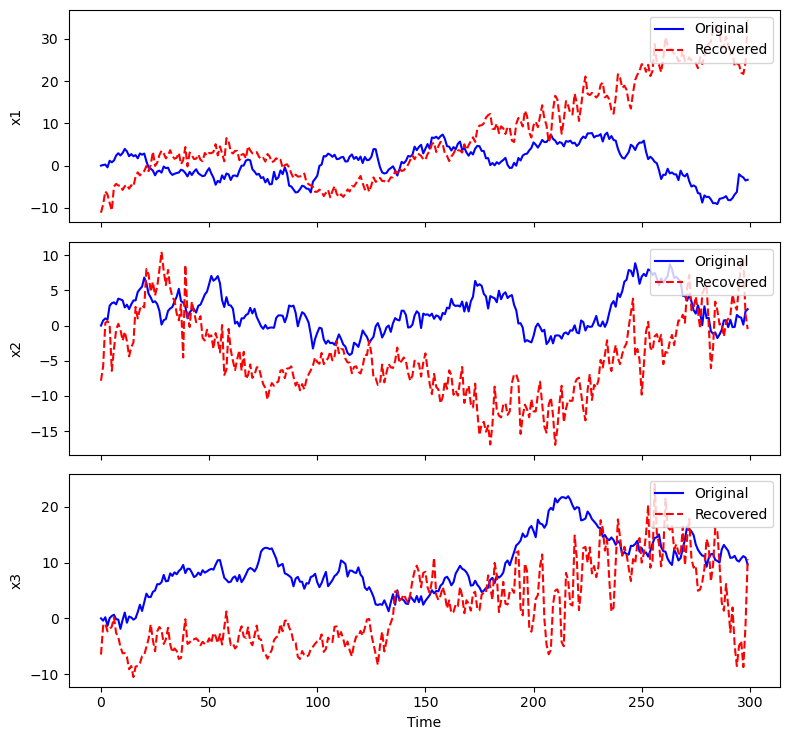

In [270]:
import numpy as np
import torch
import signatory  

def invert_signature(
    sig_target_np,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.05,
    n_iter=2000
):
    """
    Invert a given signature vector into a path using gradient descent.
    
    Parameters:
        sig_target_np: numpy array of shape (signature_length,)
        n_steps: int, number of steps in the path (without basepoint)
        spatial_dim: int, spatial dimension of the path
        depth: int, signature depth
        time_increment: float, spacing for time augmentation channel
        lr: float, learning rate for optimizer
        n_iter: int, number of optimization iterations

    Returns:
        recovered_spatial: np.array of shape (n_steps, spatial_dim)
        losses: list of loss values during optimization
    """

    # Convert target signature vector to torch tensor, add batch dimension
    sig_target = torch.tensor(sig_target_np, dtype=torch.float32).unsqueeze(0)

    # Initialise spatial path as a random walk WITHOUT basepoint
    spatial_noise = np.cumsum(np.random.randn(n_steps, spatial_dim).astype(np.float32), axis=0)
    
    # Add basepoint at origin (first point fixed)
    spatial_path = np.vstack([np.zeros((1, spatial_dim), dtype=np.float32), spatial_noise])  # shape (n_steps + 1, d)
    
    # Time augmentation vector
    n_aug = spatial_path.shape[0]
    time = (time_increment * np.arange(n_aug)).reshape(-1, 1).astype(np.float32)
    
    # Combine time and spatial into full path with time as first channel
    init_path = np.concatenate([time, spatial_path], axis=1)  # shape (n_steps + 1, spatial_dim + 1)

    y = torch.tensor(init_path, dtype=torch.float32).unsqueeze(0)  # shape (1, n_steps + 1, spatial_dim + 1)

    # Only optimise spatial part, exclude time channel
    y_spatial = y[:, :, 1:].clone().detach().requires_grad_(True)  # shape (1, n_steps + 1, spatial_dim)

    optimizer = torch.optim.Adam([y_spatial], lr=lr)

    losses = []

    for iter_idx in range(n_iter):
        optimizer.zero_grad()

        # Fix basepoint (first spatial point) at zero during optimisation
        with torch.no_grad():
            y_spatial[:, 0, :] = 0.0

        # Rebuild full path including time channel
        y_full = torch.cat([y[:, :, :1], y_spatial], dim=2)  # shape (1, n_steps+1, spatial_dim+1)

        # Compute signature at specified depth
        sig_y = signatory.signature(y_full, depth)

        # Loss = L2 norm between candidate signature and target signature
        loss = torch.norm(sig_y - sig_target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if iter_idx % 200 == 0 or iter_idx == n_iter - 1:
            print(f"Iter {iter_idx}: Loss = {loss.item():.6f}")

    # Return recovered spatial path excluding the basepoint 
    recovered_spatial = y_spatial.squeeze(0).detach().cpu().numpy()[1:]  # shape (n_steps, spatial_dim)

    return recovered_spatial, losses


# === Example usage ===

index = 320  # path index

# Get the shape from the data for that specific series
n_steps, spatial_dim = X_dict[param_val][index].shape

recovered_spatial, loss_history = invert_signature(
    reconstructed_signature,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.01,
    n_iter=6000
)

import numpy as np
import matplotlib.pyplot as plt

# Assume original and recovered have shape (T, d)
original = X_np_dict[param_val][i]       # shape (T, d)
recovered = recovered_spatial            # shape (T, d)
d = original.shape[1]
assert recovered.shape[1] == d

# Error metrics
diff = original - recovered
rmse = np.sqrt(np.mean(diff**2))
mae = np.mean(np.abs(diff))
print(f"RMSE: {rmse:.6f}, MAE: {mae:.6f}")

# Plot x_i vs time
T = original.shape[0]
time = np.arange(T)

fig, axs = plt.subplots(d, 1, figsize=(8, 2.5 * d), sharex=True)

for i in range(d):
    ax = axs[i] if d > 1 else axs
    ax.plot(time, original[:, i], label='Original', color='blue')
    ax.plot(time, recovered[:, i], label='Recovered', color='red', linestyle='--')
    ax.set_ylabel(f'x{i+1}')
    ax.legend(loc='upper right')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()



## Signature Inversion with Stochastic Gradient Descent

Iter 0: Loss = 4857372672.000000
Iter 200: Loss = 2990625280.000000
Iter 400: Loss = 2423461632.000000
Iter 600: Loss = 2163948032.000000
Iter 800: Loss = 1829319680.000000
Iter 1000: Loss = 1614236800.000000
Iter 1200: Loss = 1439823616.000000
Iter 1400: Loss = 1331297664.000000
Iter 1600: Loss = 1313763712.000000
Iter 1800: Loss = 1231657984.000000
Iter 2000: Loss = 1216381824.000000
Iter 2200: Loss = 1182470656.000000
Iter 2400: Loss = 1227193600.000000
Iter 2600: Loss = 1320587648.000000
Iter 2800: Loss = 1237981696.000000
Iter 3000: Loss = 1256065280.000000
Iter 3200: Loss = 1145905920.000000
Iter 3400: Loss = 1329593088.000000
Iter 3600: Loss = 1328327296.000000
Iter 3800: Loss = 1225810688.000000
Iter 4000: Loss = 1347959552.000000
Iter 4200: Loss = 1289179904.000000
Iter 4400: Loss = 1102670080.000000
Iter 4600: Loss = 1210872320.000000
Iter 4800: Loss = 1292287232.000000
Iter 4999: Loss = 1280007936.000000
RMSE: 14.606151, MAE: 11.602285


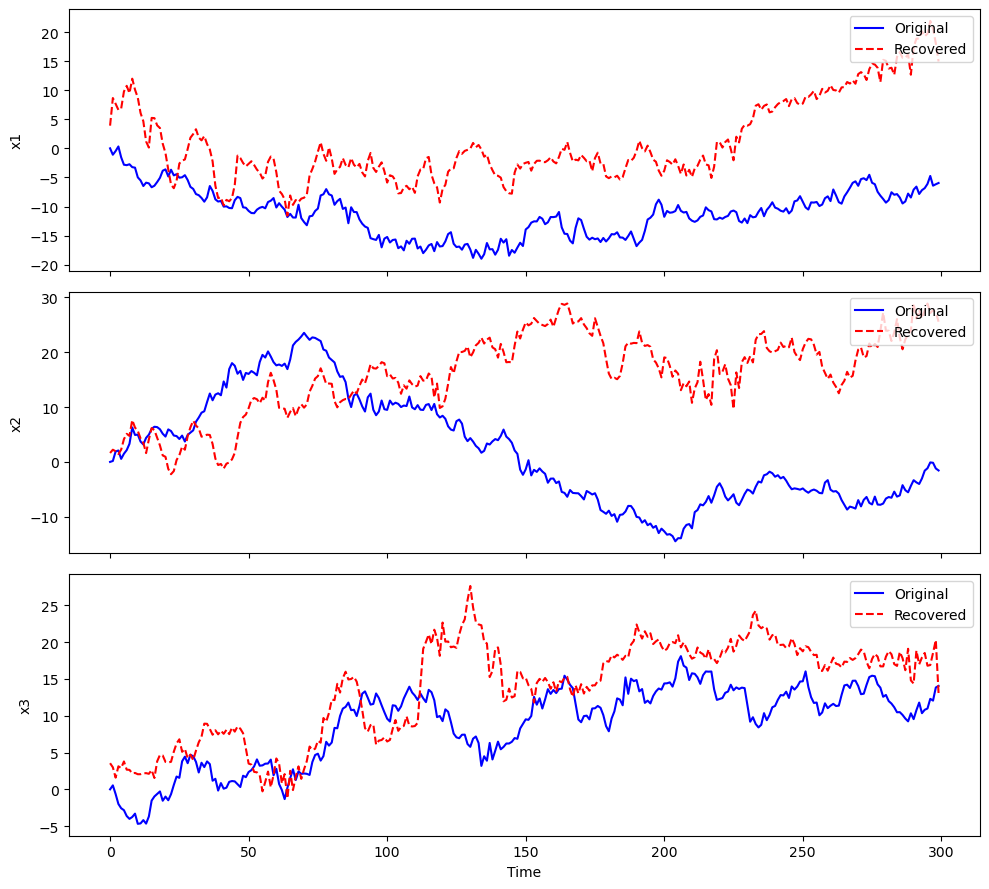

In [233]:
import numpy as np
import torch
import signatory
import matplotlib.pyplot as plt

def invert_signature_sgd(
    sig_target_np,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.02,
    n_iter=2000,
    batch_fraction=0.8,  # fraction of remaining coeffs to randomly select
):

    sig_target = torch.tensor(sig_target_np, dtype=torch.float32).unsqueeze(0)

    spatial_noise = np.cumsum(np.random.randn(n_steps, spatial_dim).astype(np.float32), axis=0)
    spatial_path = np.vstack([np.zeros((1, spatial_dim), dtype=np.float32), spatial_noise])

    n_aug = spatial_path.shape[0]
    time = (time_increment * np.arange(n_aug)).reshape(-1, 1).astype(np.float32)
    init_path = np.concatenate([time, spatial_path], axis=1)

    y = torch.tensor(init_path, dtype=torch.float32).unsqueeze(0)
    y_spatial = y[:, :, 1:].clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([y_spatial], lr=lr)

    sig_len = sig_target_np.shape[0]
    losses = []

    # Always keep first d+1 indices (first level signature terms)
    fixed_indices = np.arange(spatial_dim + 1)  # indices 0 to d inclusive

    # Remaining indices (exclude first level)
    remaining_indices = np.arange(spatial_dim + 1, sig_len)

    batch_size = int(batch_fraction * len(remaining_indices))

    for iter_idx in range(n_iter):
        optimizer.zero_grad()
        with torch.no_grad():
            y_spatial[:, 0, :] = 0.0

        y_full = torch.cat([y[:, :, :1], y_spatial], dim=2)
        sig_y = signatory.signature(y_full, depth)

        # Randomly select a batch from the remaining indices
        selected_remaining = np.random.choice(remaining_indices, size=batch_size, replace=False)

        # Combine fixed indices with randomly selected remaining indices
        batch_indices = np.concatenate([fixed_indices, selected_remaining])
        batch_indices = torch.tensor(batch_indices, dtype=torch.long)

        loss = torch.norm(sig_y[:, batch_indices] - sig_target[:, batch_indices])
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if iter_idx % 200 == 0 or iter_idx == n_iter - 1:
            print(f"Iter {iter_idx}: Loss = {loss.item():.6f}")

    recovered_spatial = y_spatial.squeeze(0).detach().cpu().numpy()[1:]

    return recovered_spatial

# Example usage
recovered_spatial = invert_signature_sgd(
    reconstructed_signature,
    n_steps,
    spatial_dim,
    depth,
    lr=0.02,
    n_iter=5000,
    batch_fraction=0.8
)


# === Plotting original vs recovered ===

original = X_np_dict[param_val][index]  # shape (T, d)
recovered = recovered_spatial
d = original.shape[1]

assert recovered.shape[1] == d

diff = original - recovered
rmse = np.sqrt(np.mean(diff**2))
mae = np.mean(np.abs(diff))
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

T = original.shape[0]
time = np.arange(T)

fig, axs = plt.subplots(d, 1, figsize=(10, 3 * d), sharex=True)

for i in range(d):
    ax = axs[i] if d > 1 else axs
    ax.plot(time, original[:, i], label='Original', color='blue')
    ax.plot(time, recovered[:, i], label='Recovered', color='red', linestyle='--')
    ax.set_ylabel(f'x{i+1}')
    ax.legend(loc='upper right')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


## Compression ratio

In [290]:
compression_ratio = (num_samples * d * len_x) / ((num_pcs + 1) * reconstructed_signature.shape[0] + num_pcs * num_samples)
print("Compression ratio is:", compression_ratio)


Compression ratio is: 12.450888163355653


In [292]:
reconstructed_signature.shape[0] 

1364

## Logsignature Inversion with Gradient Descent (differentiability issues)

## Compression Ratio for Log-Signature

## Sparse Signature Inversion with Standard Gradient Descent
## Here, we only look at time-augmented signature coordinates of the form (1, ..., 1, k)

Iter    1  Loss = 7807223296.000000
Iter  200  Loss = 4337111040.000000
Iter  400  Loss = 1410391936.000000
Iter  600  Loss = 17677332.000000
Iter  800  Loss = 17575772.000000
Iter 1000  Loss = 17465732.000000
Iter 1200  Loss = 17348194.000000
Iter 1400  Loss = 17222016.000000
Iter 1600  Loss = 17086094.000000
Iter 1800  Loss = 16954724.000000
Iter 2000  Loss = 16781136.000000
Iter 2200  Loss = 16609082.000000
Iter 2400  Loss = 16423333.000000
Iter 2600  Loss = 16248396.000000
Iter 2800  Loss = 16005384.000000
Iter 3000  Loss = 15770995.000000
Iter 3200  Loss = 15518178.000000
Iter 3400  Loss = 15246226.000000
Iter 3600  Loss = 15009880.000000
Iter 3800  Loss = 14640705.000000
Iter 4000  Loss = 14303689.000000
Iter 4200  Loss = 14022316.000000
Iter 4400  Loss = 13582896.000000
Iter 4600  Loss = 13199360.000000
Iter 4800  Loss = 12789614.000000
Iter 5000  Loss = 12357589.000000
Iter 5200  Loss = 11900322.000000
Iter 5400  Loss = 11411626.000000
Iter 5600  Loss = 10947570.000000
Iter 580

KeyError: 6

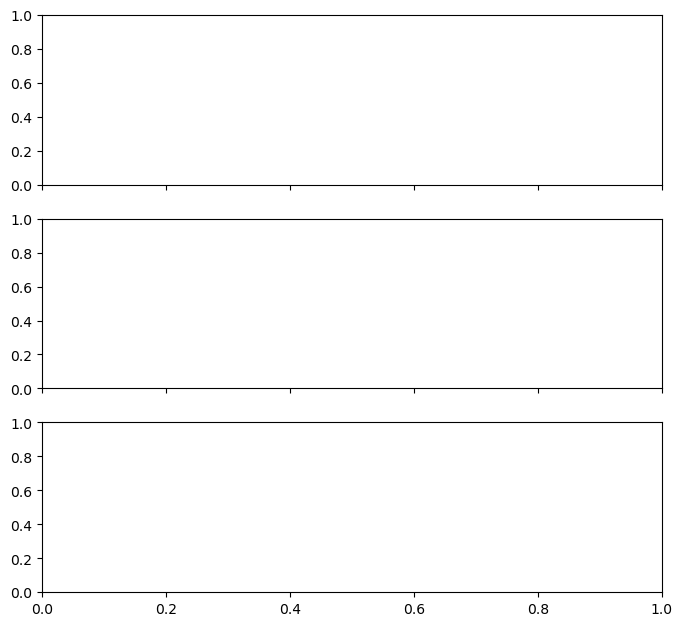

In [282]:
import numpy as np
import torch
import signatory
import matplotlib.pyplot as plt



def compute_selected_positions(spatial_dim: int, depth: int):
    """
    Return a sorted list of 0‐based indices in the flattened signature
    vector for multi‐indices (1,...,1,k), k > 1 up to given depth.
    """
    channels = spatial_dim + 1
    selected = []
    for L in range(1, depth+1):
        base = sum(channels**l for l in range(1, L))
        for k in range(2, channels+1):
            pos = base + (k - 1)
            selected.append(pos)
    return sorted(selected)


def invert_signature(
    sig_target_np: np.ndarray,
    n_steps: int,
    spatial_dim: int,
    depth: int,
    selected_positions: list,
    time_increment: float = 1.0,
    lr: float = 0.1,
    n_iter: int = 2000
):
    """
    Invert a signature by matching all `selected_positions` coefficients each iteration.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Convert target signature to tensor
    sig_target = torch.tensor(sig_target_np, dtype=torch.float32, device=device)

    # Initialise spatial path with random noise
    spatial_noise = np.cumsum(
        np.random.randn(n_steps, spatial_dim).astype(np.float32),
        axis=0
    )
    spatial_path = np.vstack([np.zeros((1, spatial_dim), dtype=np.float32), spatial_noise])
    T_aug = spatial_path.shape[0]
    time_chan = (time_increment * np.arange(T_aug, dtype=np.float32))[:, None]

    init = np.concatenate([time_chan, spatial_path], axis=1)  # (T_aug, d+1)
    y = torch.tensor(init, dtype=torch.float32, device=device).unsqueeze(0)

    y_spatial = y[:, :, 1:].clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([y_spatial], lr=lr)
    losses = []

    # Use all selected coefficients every iteration
    batch_idxs = torch.tensor(selected_positions, dtype=torch.long, device=device)

    for it in range(1, n_iter + 1):
        optimizer.zero_grad()

        # fix basepoint
        with torch.no_grad():
            y_spatial[:, 0, :] = 0.0

        # rebuild full path
        y_full = torch.cat([y[:, :, :1], y_spatial], dim=2)
        sig_full = signatory.signature(y_full, depth).squeeze(0)

        pred_batch = sig_full[batch_idxs]
        targ_batch = sig_target[batch_idxs]

        loss = torch.norm(pred_batch - targ_batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if it % 200 == 0 or it == 1 or it == n_iter:
            print(f"Iter {it:4d}  Loss = {loss.item():.6f}")

    rec = y_spatial.detach().cpu().squeeze(0).numpy()[1:]
    return rec, losses


# === Example usage ===

# 1) Compute the positions you care about once
selected_positions = compute_selected_positions(spatial_dim, depth)

# 2) Call the inverter, sampling 15 coefficients each iteration
recovered_spatial, loss_history = invert_signature(
    sig_target_np       = reconstructed_signature,
    n_steps             = n_steps,
    spatial_dim         = spatial_dim,
    depth               = depth,
    selected_positions  = selected_positions,
    time_increment      = 1.0,
    lr                  = 0.02,
    n_iter              = 7000
)

# 3) Plot original vs recovered
T = recovered_spatial.shape[0]
time = np.arange(T)
fig, axs = plt.subplots(spatial_dim, 1, figsize=(8, 2.5*spatial_dim), sharex=True)
for i in range(spatial_dim):
    axs[i].plot(time,
                X_dict[param_val][index][:, i],
                label='Original')
    axs[i].plot(time,
                recovered_spatial[:, i],
                '--', label='Recovered')
    axs[i].set_ylabel(f'x{i+1}')
    axs[i].legend()
axs[-1].set_xlabel('Time step')
plt.tight_layout()
plt.show()



In [294]:
# Convert to NumPy if needed
if isinstance(original, torch.Tensor):
    original = original.detach().cpu().numpy()
if isinstance(recovered, torch.Tensor):
    recovered = recovered.detach().cpu().numpy()

# Compute overall MAE and RMSE
abs_err = np.abs(original - recovered)
sqr_err = (original - recovered) ** 2

mae = np.mean(abs_err)
rmse = np.sqrt(np.mean(sqr_err))

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")



MAE  = 8.4225
RMSE = 11.0313


## Compression Ratio

In [286]:
compression_ratio = (num_samples * d * len_x) / ((num_pcs+1)*d*5 + num_pcs * num_samples)
print("Compression ratio is:", compression_ratio)

Compression ratio is: 29.542097488921712
